In [105]:
!pip install scikit-surprise

Importing the necessary Python libraries and modules that we'll be using for our data analysis and recommendation system.

In [106]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from surprise.model_selection.split import KFold
from surprise.model_selection import GridSearchCV
from surprise import Dataset, Reader
from surprise import SVD
from surprise import KNNWithMeans
from surprise import NormalPredictor
from surprise.model_selection import cross_validate

In this step, we are loading the MovieLens Ratings dataset from a CSV file using the pandas library.

*DATA INSPECTION AND DATA PREPING*

In [107]:
data = pd.read_csv('C:/Users/mw/Desktop/DSS/Analysis of Customer Data/Practical session/MovieLens-Ratings.csv')

Checking how the data look like, displaying the first 10 rows of the dataset

In [108]:
data.head(10)

,userId,movieId,rating,timestamp
0,1,307,3.5,1256677221
1,1,481,3.5,1256677456
2,1,1091,1.5,1256677471
3,1,1257,4.5,1256677460
4,1,1449,4.5,1256677264
5,1,1590,2.5,1256677236
6,1,1591,1.5,1256677475
7,1,2134,4.5,1256677464
8,1,2478,4.0,1256677239
9,1,2840,3.0,1256677500


Because ratings are on a five-star scale, with half-star increments (0.5 stars - 5.0 stars), we are checking all values in rating column are between 0.5 and 5.

In [109]:
min_rating= data['rating'].min()
max_rating= data['rating'].max()

print(min_rating)
print(max_rating)

0.5
5.0


In [110]:
invalid_ratings = data[(data['rating'] < 0.5) | (data['rating'] > 5)]

if not invalid_ratings.empty:
    print("Invalid Ratings:")
    print(invalid_ratings)
else:
    print("All ratings are within the 0.5-5 range.")

All ratings are within the 0.5-5 range.


Here we are trying to understand better the timestamp variable, and checking the corresponding years from these datetime objects. Knowing that timestamps represent seconds since mid-night Coordinated Universal Time (UTC) of January 1, 1970.

In [111]:
min_timestamp= data['timestamp'].min()
max_timestamp= data['timestamp'].max()

print(min_timestamp)
print(max_timestamp)

min_date = datetime.datetime.utcfromtimestamp(min_timestamp)
max_date = datetime.datetime.utcfromtimestamp(max_timestamp)

min_year = min_date.year
max_year = max_date.year

min_year, max_year

789652004
1537945149


(1995, 2018)

Timestamps typically represent the moment at which a user rated or otherwise interacted with an item. Although this variable could be informative to identify trends and popular movies, this dataset was last updated on 2018, so it would already be considered outdated to understand current trends of 2023. On top of this, dropping the "timestamp" variable will help us simplifying the dataset and the process, leading into a cleaner and more interpretable model.

In [112]:
data = data.drop(columns=['timestamp'])

Looking for any Missing Values

In [113]:
data.isnull().any() 

userId     False
movieId    False
rating     False
dtype: bool

In [114]:
print(data.info())
print(data.shape[0])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27753444 entries, 0 to 27753443
Data columns (total 3 columns):
 #   Column   Dtype  
---  ------   -----  
 0   userId   int64  
 1   movieId  int64  
 2   rating   float64
dtypes: float64(1), int64(2)
memory usage: 635.2 MB
None
27753444


In [115]:
data.describe()


,userId,movieId,rating
count,2.775344e+07,2.775344e+07,2.775344e+07
mean,1.419420e+05,1.848800e+04,3.530445e+00
std,8.170740e+04,3.510263e+04,1.066353e+00
min,1.000000e+00,1.000000e+00,5.000000e-01
25%,7.117600e+04,1.097000e+03,3.000000e+00
50%,1.420220e+05,2.716000e+03,3.500000e+00
75%,2.124590e+05,7.150000e+03,4.000000e+00
max,2.832280e+05,1.938860e+05,5.000000e+00


Let's plot a Box Plot to identify eventual outliers on the "rating" variable

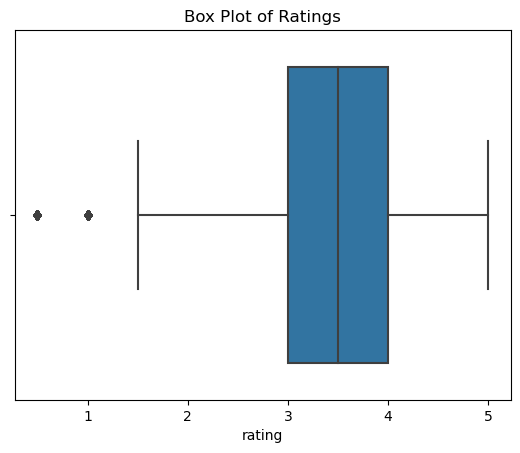

Summary Statistics:
count    2.775344e+07
mean     3.530445e+00
std      1.066353e+00
min      5.000000e-01
25%      3.000000e+00
50%      3.500000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64
Number of Outliers: 1328621
Outliers:
          userId  movieId  rating
59             4       44     1.0
65             4       65     0.5
66             4       66     0.5
79             4      158     0.5
84             4      169     0.5
...          ...      ...     ...
27753277  283224     1389     1.0
27753303  283226       65     1.0
27753307  283226      420     1.0
27753308  283226      502     1.0
27753427  283228     5706     1.0

[1328621 rows x 3 columns]


In [116]:
Q1 = data['rating'].quantile(0.25)
Q3 = data['rating'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = data[(data['rating'] < lower_bound) | (data['rating'] > upper_bound)]

sns.boxplot(x=data['rating'])
plt.title('Box Plot of Ratings')
plt.show()

print("Summary Statistics:")
print(data['rating'].describe())
print("Number of Outliers:", len(outliers))
print("Outliers:")
print(outliers)


We implemented a user filtering approach to exclude individuals with unusual rating habits, specifically those who consistently give extremely high or extremely low ratings to more than 20 movies. This step was taken to emphasize users with more typical and balanced rating behavior, ensuring that the analysis and recommendations are not excessively impacted by outliers. In this particular context, having a total average score of either 0.5 or a 5 after having rated at least 20 movies was flagged as extreme behaviour.

In [117]:
user_avg_ratings = data.groupby('userId')['rating'].mean().reset_index()

user_movie_counts = data.groupby('userId')['movieId'].nunique().reset_index()

user_info = pd.merge(user_avg_ratings, user_movie_counts, on='userId')

filtered_users = user_info[((user_info['rating'] < 0.6) | (user_info['rating'] == 5.0)) & (user_info['movieId'] >= 20)]

print(filtered_users)

        userId  rating  movieId
879        880     0.5       20
1474      1475     5.0      106
2334      2335     5.0       31
2612      2613     5.0       20
3331      3332     5.0       97
...        ...     ...      ...
274068  274069     5.0       35
274072  274073     5.0       53
276868  276869     5.0       28
278486  278487     5.0       64
279674  279675     5.0       68

[209 rows x 3 columns]


We check how many individual movie reviews were written by the filtered users. It turned out that only 10263 out of 27753444 were dropped, so this will not affect the integrity of our dataset.

In [118]:
num_users_filtered = filtered_users.shape[0]

num_unique_users_original = user_info['userId'].nunique()

total_reviews_filtered_users = filtered_users['movieId'].sum()

total_reviews_original = data.shape[0]

print("Number of Users Filtered:", num_users_filtered)
print("Number of Unique Users in Original Data:", num_unique_users_original)
print("Total Reviews by Filtered Users:", total_reviews_filtered_users)
print("Total Reviews in Original Data:", total_reviews_original)

Number of Users Filtered: 209
Number of Unique Users in Original Data: 283228
Total Reviews by Filtered Users: 10263
Total Reviews in Original Data: 27753444


Dropping the discussed filtered users.

In [119]:
data = data[~data['userId'].isin(filtered_users['userId'])]

Computing basic statistics: number of unique users and unique movies.

In [120]:
unique_users = len(data['userId'].unique())
unique_movie = len(data['movieId'].unique())

print('unique users: ' + str(unique_users))
print('unique movies: ' + str(unique_movie))

unique users: 283019
unique movies: 53878


Because not every movie is going to recieve an equal number of users's ratings, we are running the probability density function. As seen in the figure below, a few thousand movies have all the ratings, while the majority of movies have very few if any. It is hard to draw conclusions or know when to recommend movies with little or no ratings.

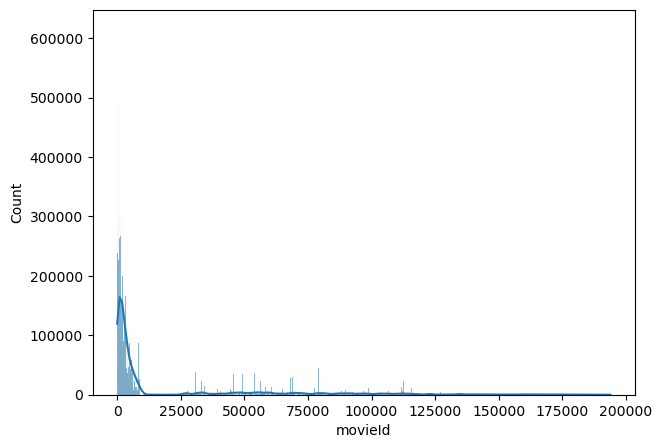

In [121]:
def plot_density(data):
    fig, ax = plt.subplots(figsize=(7,5))
    plot = sns.histplot(data['movieId'], kde=True, ax=ax)

plot_density(data)

Relative frequency of top-k items. The figure below suggests that k=5000 is a reasonable setting since the frequency distribution graph plateaus at around 5000. 

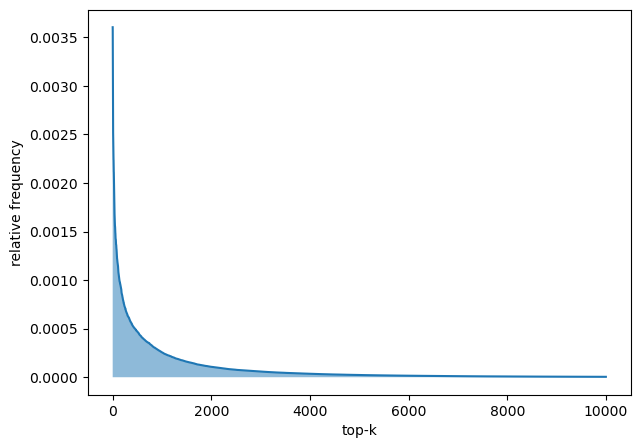

In [122]:
def plot_frequency(df, k):
    
    fig, ax = plt.subplots(figsize=(7,5))
    counts = data['movieId'].value_counts(sort=True, ascending=False)
    orig = counts.index.tolist()
    counts2 = counts.reset_index(inplace=False, drop=True)
    sub = counts2.index.tolist()

    sns.lineplot(x=counts2.index[0:k], y=counts2[0:k]/counts2[0:k].sum(), ax=ax)
    ax.fill_between(counts2.index[0:k], counts2[0:k]/counts2[0:k].sum(), alpha=0.5)
    ax.set_ylabel("relative frequency")
    ax.set_xlabel("top-k")

plot_frequency(data, k=10000)

Selecting the top-5000 items to build our recommender system.

In [123]:
def select(df, k, col):

    top_values = df[col].value_counts().nlargest(k)
    return df.loc[df[col].isin(top_values.index)]

data= select(data, k=5000, col='movieId')

Counting unique users & movies after selecting the top 5000 items.

In [124]:
unique_users = len(data['userId'].unique())
unique_movie = len(data['movieId'].unique())

print('unique users: ' + str(unique_users))
print('unique movie: ' + str(unique_movie))

unique users: 282631
unique movie: 5000


Creating a new dataset with the top 5000 items.

In [125]:
data = data.iloc[:5000,:]
data.shape

(5000, 3)

Creating a reader object.

In [126]:
reader = Reader(rating_scale=(0.5, 5))

data = Dataset.load_from_df(data[['userId', 'movieId', 'rating']], reader)


*PERFORMANCE METRICS*

To evaluate the performance of our models the metrics chosen are Root Mean Squared Error (RMSE) and MAE (Mean Absolute Error). They are both well suited to evaluate regression tasks like a the one at hand. RMSE =  Square Root of [(1/n) * Sum of (y_i - ŷ_i)^2]. Provides information about the magnitude of prediction errors. Meanwhile, MAE, MAE = (1/n) * Sum of |y_i - ŷ_i|, gives us a measure of the average abolsute deviation. RMSE is more sensitive to outliers, which our data has, because it penalizes large errors more. MAE is more robust to outliers and therefore might be a more reliable in this data.
​

*MODELS*

Normal Predictor will be our baseline. It assumes that ratings are normally distributed, and makes recommendations completely at random, without considering any user-item interactions or patterns in the data. 

In [127]:
np.random.seed(31415)
cv = KFold(n_splits=5, random_state=42, shuffle=True)

results = cross_validate(NormalPredictor(), data, cv=cv, return_train_measures=True)

df = pd.DataFrame(results)
df.rename(columns={
    'test_rmse': 'Test RMSE',
    'test_mae': 'Test MAE',
    'train_rmse': 'Train RMSE',
    'train_mae': 'Train MAE'
}, inplace=True)

print("Cross-Validation Results:")
print(df[['Train RMSE', 'Test RMSE', 'Train MAE', 'Test MAE', 'fit_time', 'test_time']])

Cross-Validation Results:
   Train RMSE  Test RMSE  Train MAE  Test MAE  fit_time  test_time
0    1.456056   1.456890   1.154974  1.162641  0.003993   0.004040
1    1.462929   1.405625   1.166036  1.120921  0.003994   0.008233
2    1.447764   1.455049   1.147887  1.153423  0.003991   0.007952
3    1.460203   1.457269   1.155487  1.165028  0.007955   0.000000
4    1.464784   1.400820   1.166259  1.126190  0.003987   0.000000


We test the RMSE and MAE for both the test & the train set to detect overfitting. We store the results to later include them in a final table & graph.

In [128]:
test_rmse_values = results['test_rmse']
train_rmse_values = results['train_rmse']
test_mae_values = results['test_mae']
train_mae_values = results['train_mae']

mean_test_rmse_normal = np.mean(test_rmse_values)
mean_train_rmse_normal = np.mean(train_rmse_values)
mean_test_mae_normal = np.mean(test_mae_values)
mean_train_mae_normal = np.mean(train_mae_values)

The first selected method is a neighbordhood method; KNN With Means. This method is appropiate for the type of data presented as it mitigates the impact of bias present in the data. As we saw in the outlier analysis, we are dealing with a skewed distribution. By considering the similarities between users or items (in our case it will prove more effective to consider users), it can provide recommendations based on relative preferences rather than just the global mean. The hyperparameters to be tuned for this method are the following:
- k: k is the number of nearest neighbors to consider. Smaller values of k picks up local patterns while larger k values make the model more robust but they can miss important patterns in the data making them less accurate.  
- Name: it is a similarity metric. Essentially it is the choice of which method to measure distance/similarity between points, as to decide which neighbors are nearest. The possible metrics in our case are cosine similarity and Pearson correlation. Cosine similarity is often used in recommendation systems, so we expect it to perform well in this context. It is a robust method and performs well with sparse data. The other possible metric is Pearson correlation, which assumes a linear relationship in the data. 
- User_based: this variable is a boolean to indicate whether the model should consider users or items to find similarities between. The algorithm would try to find users with similar interests while items would try to evaluate similarities between movies. Since little information aside from rating is offered about the movies, probably similarities between user interests (those who liked or disliked the same movies) make more sense in this context.

In [129]:
np.random.seed(31415)

param_grid = {
    'k': [10, 15, 20, 25, 30],  # Number of neighbors to consider
    'sim_options': {
        'name': ['cosine', 'pearson'],  # Similarity measure
        'user_based': [True, False]  # Whether to use user-based or item-based collaborative filtering
    }   , 
    'verbose': [False]
 }


grid_search = GridSearchCV(KNNWithMeans, param_grid, measures=['RMSE', 'MAE'],cv=KFold(5, random_state=42))

grid_search.fit(data)

best_params = grid_search.best_params
best_results = grid_search.best_score

print("Best Parameters:")
for param, value in best_params.items():
    print(f"{param}: {value}")

print("\nBest Results (RMSE and MAE):")
for metric, value in best_results.items():
    print(f"{metric}: {value}")

Best Parameters:
rmse: {'k': 20, 'sim_options': {'name': 'cosine', 'user_based': True}, 'verbose': False}
mae: {'k': 20, 'sim_options': {'name': 'cosine', 'user_based': True}, 'verbose': False}

Best Results (RMSE and MAE):
rmse: 1.0719182390518498
mae: 0.8293992387918943


Above hyperparameters were tuned using GirdSearch Cross Validation and now the model will be run on the optimal hyperparameter configuration. Then the results will be displayed in a table, a brief discussion follows:

In the comparison between Test and Train, we see that for both RMSE and MAE the training is outperforming (smaller values) the test set. This means there is overfitting at play -overfitting could be solved by a higher k value however, k=20 was the optimal parameter chosen by gridsearch cross validation in the previous section. The results are consistent within the 5 folds. 

In [130]:
results = cross_validate(KNNWithMeans(k=20,  sim_options={'name':'cosine', 'user_based':True}, verbose=False), data, cv=cv, return_train_measures=True)

df = pd.DataFrame(results)
df.rename(columns={
    'test_rmse': 'Test RMSE',
    'test_mae': 'Test MAE',
    'train_rmse': 'Train RMSE',
    'train_mae': 'Train MAE'
}, inplace=True)

print("Cross-Validation Results:")
print(df[['Train RMSE', 'Test RMSE', 'Train MAE', 'Test MAE', 'fit_time', 'test_time']])

Cross-Validation Results:
   Train RMSE  Test RMSE  Train MAE  Test MAE  fit_time  test_time
0    0.634581   1.089065   0.433276  0.844419  0.006000   0.020975
1    0.632877   1.056129   0.431702  0.810433  0.002998   0.012026
2    0.637996   1.084251   0.435874  0.844309  0.005994   0.012033
3    0.636342   1.054842   0.432867  0.817001  0.005432   0.011993
4    0.637467   1.075303   0.435042  0.830833  0.002998   0.014983


In the cell below the mean between those 5 fold is calculated for each, and results are stored for later usage.

In [131]:
test_rmse_values = results['test_rmse']
train_rmse_values = results['train_rmse']
test_mae_values = results['test_mae']
train_mae_values = results['train_mae']

mean_test_rmse_knn = np.mean(test_rmse_values)
mean_train_rmse_knn = np.mean(train_rmse_values)
mean_test_mae_knn = np.mean(test_mae_values)
mean_train_mae_knn = np.mean(train_mae_values)

Since our dataset only had three features (userId, movieId, rating), we choose the simplest matrix factorization method, SVD. This algorithm can capture both user and item biases using matrix factorization and this comes handy with our dataset, since our data presents a positive skewness. Moreover this algorithm can handle the cold start problem better than more advanced methods such as SVD++, meaning it can still perform well with users with little review history. The hyperparameters tuned for this algorithm are:
- n_factors: The number of factors hyperparameter determines the number of latent factors used for matrix factorization. A higher number of factors may capture more intricate user-item interactions but can also lead to overfitting, while a lower number simplifies the representation. 
- reg_all: Regularization term is a technique used to prevent overfitting. It adds a penalty term to the function to be optimized to discourage complex model solutions. The regularization term is refered to lambda in the optimization function and the possible values chosen to be selected from are 0.01, 0.02 and 0.05.
- lr_all: The Learnings Rate controls the step size during the optimization process. A small learning rate can be very computationally expensive and time consuming, but a learning rate that is too large might risk overshooting the optimal solution. 
- n_epochs: The Number of Epochs is the number of iterations, which are the number of times the model updates its parameters during training.
- biased: This parameter is a boolean which indicates whether to include bias term in the model. As mentioned above, our data is positively skewed so we expect the bias term to be useful and therefore included.

In [132]:
np.random.seed(31415)

param_grid = {
    'n_factors': [2, 5, 10],            # Number of latent factors
    'reg_all': [0.01, 0.02, 0.05],        # Regularization term (lambda)
    'lr_all': [0.002, 0.005, 0.01],       # Learning rate
    'n_epochs': [5,10,15,20],                 # Number of iterations
    'biased': [True, False]              # Bias terms
}

grid_search = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=KFold(5, random_state=42))
grid_search.fit(data)

best_params = grid_search.best_params
best_results = grid_search.best_score

print("Best Parameters:")
for param, value in best_params.items():
    print(f"{param}: {value}")
print("\nBest Results (RMSE and MAE):")
for metric, value in best_results.items():
    print(f"{metric}: {value}")

Best Parameters:
rmse: {'n_factors': 2, 'reg_all': 0.05, 'lr_all': 0.01, 'n_epochs': 15, 'biased': True}
mae: {'n_factors': 5, 'reg_all': 0.05, 'lr_all': 0.01, 'n_epochs': 20, 'biased': True}

Best Results (RMSE and MAE):
rmse: 0.9590446050529178
mae: 0.7420557380039059


Above hyperparameters were tuned using GirdSearch Cross Validation and now the model will be run on the optimal hyperparameter configuration. Then the results will be displayed in a table, a brief discussion follows:

In the comparison between Test and Train, we see that for both RMSE and MAE the training is outperforming (smaller values) the test set. However, the overfitting is much smaller than in the KNN with means, so the chosen Regularization Term, 0.05, is working properly. 

In [133]:
results = cross_validate(SVD(n_factors=5,  reg_all=0.05, lr_all=0.01, n_epochs=15, biased=True), data, cv=cv, return_train_measures=True)

df = pd.DataFrame(results)
df.rename(columns={
    'test_rmse': 'Test RMSE',
    'test_mae': 'Test MAE',
    'train_rmse': 'Train RMSE',
    'train_mae': 'Train MAE'
}, inplace=True)

print("Cross-Validation Results:")
print(df[['Train RMSE', 'Test RMSE', 'Train MAE', 'Test MAE', 'fit_time', 'test_time']])

Cross-Validation Results:
   Train RMSE  Test RMSE  Train MAE  Test MAE  fit_time  test_time
0    0.814783   0.964183   0.629085  0.759373  0.028250   0.011992
1    0.811078   0.944770   0.632793  0.711088  0.011989   0.002997
2    0.807320   0.981586   0.626097  0.762815  0.020983   0.002999
3    0.818137   0.949934   0.633106  0.742611  0.014986   0.005995
4    0.815642   0.955639   0.631137  0.737542  0.020987   0.014987


In the cell below the mean between those 5 fold is calculated for each, and results are stored for later usage.

In [134]:
test_rmse_values = results['test_rmse']
train_rmse_values = results['train_rmse']
test_mae_values = results['test_mae']
train_mae_values = results['train_mae']

mean_test_rmse_svd = np.mean(test_rmse_values)
mean_train_rmse_svd = np.mean(train_rmse_values)
mean_test_mae_svd = np.mean(test_mae_values)
mean_train_mae_svd = np.mean(train_mae_values)

*RESULTS AND CONCLUSION*

In [135]:
results_table = {
    'Normal Predictor': {
        'Mean Test RMSE': mean_test_rmse_normal,
        'Mean Test MAE': mean_test_mae_normal,
    },
    'kNN with Means': {
        'Mean Test RMSE': mean_test_rmse_knn,
        'Mean Test MAE': mean_test_mae_knn,
    },
    'SVD': {
        'Mean Test RMSE': mean_test_rmse_svd,
        'Mean Test MAE': mean_test_mae_svd,
    },
}

results_df = pd.DataFrame(results_table)

                Normal Predictor  kNN with Means       SVD
Mean Test RMSE          1.435131        1.071918  0.959222
Mean Test MAE           1.145641        0.829399  0.742686


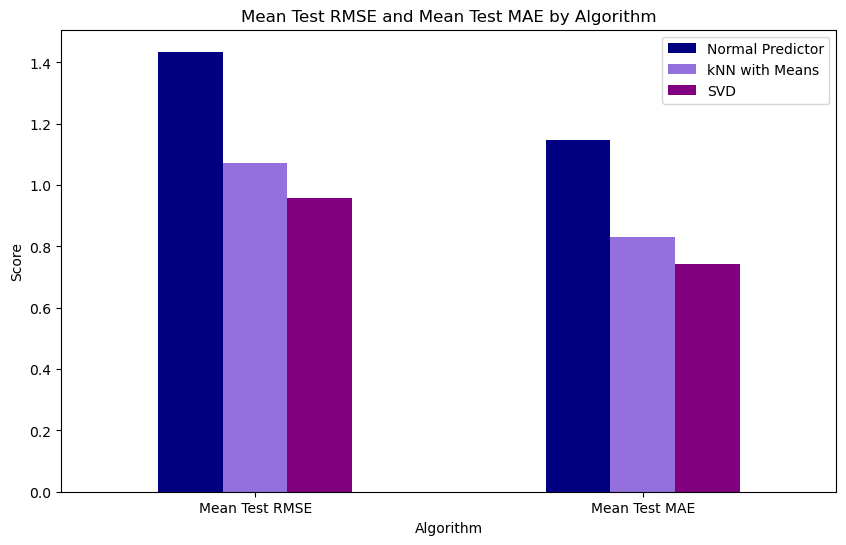

In [136]:

color_palette = ['#000080', '#9370DB', '#800080']

ax = results_df.plot(kind='bar', figsize=(10, 6), color=color_palette)
plt.title('Mean Test RMSE and Mean Test MAE by Algorithm')
plt.xlabel('Algorithm')
plt.ylabel('Score')
plt.legend(loc='best')

plt.xticks(rotation=0)  

print(results_df)
plt.show()

The table and graph above display the results on the testing set of the three models explained and trained before. A discussion on the results follows:

The graph displays the results in a more visual and more plesant to interpret way. At first glance it becomes clear that both RMSE and MAE agree on the ranking of the algorithms, albeit RMSE has higher values -as discussed before it penalizes more large errors- than MAE. The baseline model, Normal Predictor, was the worst performing model as per both evaluation metrics. While KNN with Means significantly outperformed the baseline model, it still performed slightly worse than the SVD, which was the best performing model.

The results point to SVD being the best performing, maybe because matrix factorization works best in this type of data, or perhaps because a larger number of hyperparameters were tuned for this algorithm, allowing it to be very tailored to this recommendation problem. As discussed before, while the overfitting in the SVD was very minor, for the KNN with Means model severe overfitting was observed. Despite hypertuning the number of nearest neighbors (k), the KNN was overfitting, this could be solved by increasing k.

Having more features in the model, and perhaps including *timestamp* if they were more up-to-date, as well as other information both about the movies (Genere...) and the users (Age, Sex, etc) would improve our recommendation capabilities. It would furthermore allow to use more complex models like SVD++ which would likely perform better. Furthermore, being aware that there was a positive skewness in our data, data could have been normalized during the pre-processing stage, reducing the obstacles for algorithms to offer accurate recommendations.

Overall, both our chosen models succesfully outperformed significantly the baseline model.